In [61]:
from typing import Dict, TypedDict
import decimal
from langgraph.graph import StateGraph, START, END


In [62]:
from enum import Enum

class TransactionType(Enum):
    PAYMENT_IN = "payment_in"
    PAYMENT_OUT = "payment_out"

In [63]:
class AgentState(TypedDict):
    balance: decimal
    transactionType: TransactionType
    transactionAmount: decimal
    result: str

In [64]:
def make_payment_node(state:AgentState) -> AgentState:
    state["balance"] = state["balance"] - state["transactionAmount"]
    state["result"] = f"Payment of £{state["transactionAmount"]} taken."
    return state

In [65]:
def recieve_payment_node(state:AgentState) -> AgentState:
    state["balance"] = state["balance"] + state["transactionAmount"]
    state["result"] = f"Payment of £{state["transactionAmount"]} recieved."
    return state

In [66]:
def decide_payment_type(state: AgentState) -> AgentState:
    if state["transactionType"] == TransactionType.PAYMENT_IN:
        return "recieve_operation"
    return "make_payment_operation"

In [67]:
def decide_teller_message(state:AgentState) -> AgentState:
    if state["balance"] > 0:
        return "normal_message_operation"
    return "overdraft_warning_operation"

In [68]:
def bank_teller_node(state:AgentState) -> AgentState:
    state["result"] = state["result"] + f"\nYour new balance is: £{state["balance"]}."
    return state

In [69]:
def warning_node(state:AgentState) -> AgentState:
    state["result"] = state["result"] + f"\nWarning! You are in overdraft: £{state["balance"]}."
    return state

In [70]:
graph = StateGraph(AgentState)
graph.add_node("router", lambda state:state)
graph.add_node("router_2", lambda state:state)
graph.add_node("make_payment_node", make_payment_node)
graph.add_node("recieve_payment_node", recieve_payment_node)
graph.add_node("bank_teller_node", bank_teller_node)
graph.add_node("warning_node", warning_node)

graph.add_edge(START, "router")
graph.add_conditional_edges(
    "router",
    decide_payment_type,
    {
        "make_payment_operation":"make_payment_node",
        "recieve_operation":"recieve_payment_node"
    }
)
graph.add_edge("make_payment_node", "router_2")
graph.add_edge("recieve_payment_node", "router_2")
graph.add_conditional_edges(
    "router_2",
    decide_teller_message,
    {
        "normal_message_operation" : "bank_teller_node",
        "overdraft_warning_operation" : "warning_node"
    }
)
graph.add_edge("bank_teller_node", END)
graph.add_edge("warning_node", END)
app = graph.compile()

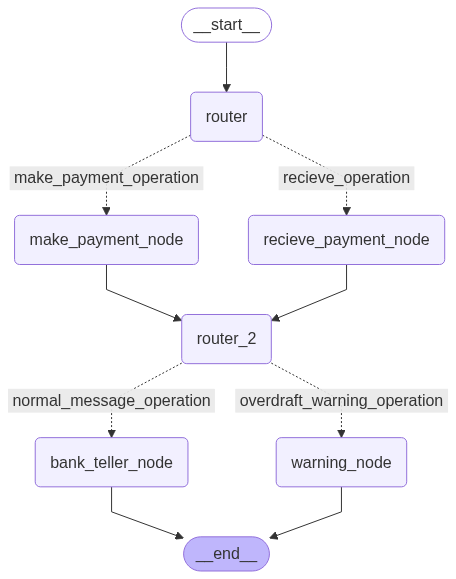

In [71]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [78]:
answer = app.invoke({"balance":2500, "transactionAmount":200, "transactionType":TransactionType.PAYMENT_OUT})

print(answer["result"])

Payment of £200 taken.
Your new balance is: £2300.
